# Daily Min Temperature in Melbourne, Australia

An optional exercise about timeseries that we were assigned in the Artificial Intelligence and Big Data degree.

Melbourne, Australia. The source of the data was created by Australian Bureau of meteorology.

## Introduction

From the daily temperature values from 1981 to 1990 he prepares two different time series models:

    1. Single step model, where from the temperature of the last seven days we are able to estimate the temperature of the next day.
    2. Multi step model, where from the temperature of the last 28 days, we estimate the temperature of the next seven days.

For the first exercise we use dense neural networks and for the second we use RNN LSTM. Remember to first analyze the time series for outliers, standardize the data, split it into training sets and then visualize the model estimates for each of the exercises.

You can create additional attributes related to the time component of the data using the sine and cosine transformations that we have seen in class.

### References

- https://raw.githubusercontent.com/jbrownlee/Datasets (Daily min temperature at Melbourne)
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://rpubs.com/thyagu1111/77258 (Predicting melbourne minimum daily temperature based on its time-series data from 1981-1990)

## Initialization

Some basic overall configuration

In [1]:
LABEL_COLUMN = 'Temp' #@param {type: 'string'}

### Imports

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Default parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Dataset

We'll load the dataset and check it's shape

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
df.shape

(3650, 2)

## Exploratory Data Analysis

A view into the data that we'll be working with, the most important aspect of this section would be to detect any sort of cyclic pattern.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


Let's also see how many years we'll be working with, since it's a daily extraction, we can do some quick math

In [5]:
len(df) / 365

10.0

And now let's get the range

In [6]:
df_date_range = df.sort_values(by='Date', ascending=True)
df_date_range['Date'].min(), df_date_range['Date'].max()

('1981-01-01', '1990-12-31')

### Overall view

Of the whole timeseries data, grouping them by year so that it's easier to detect any sort of pattern or anomaly

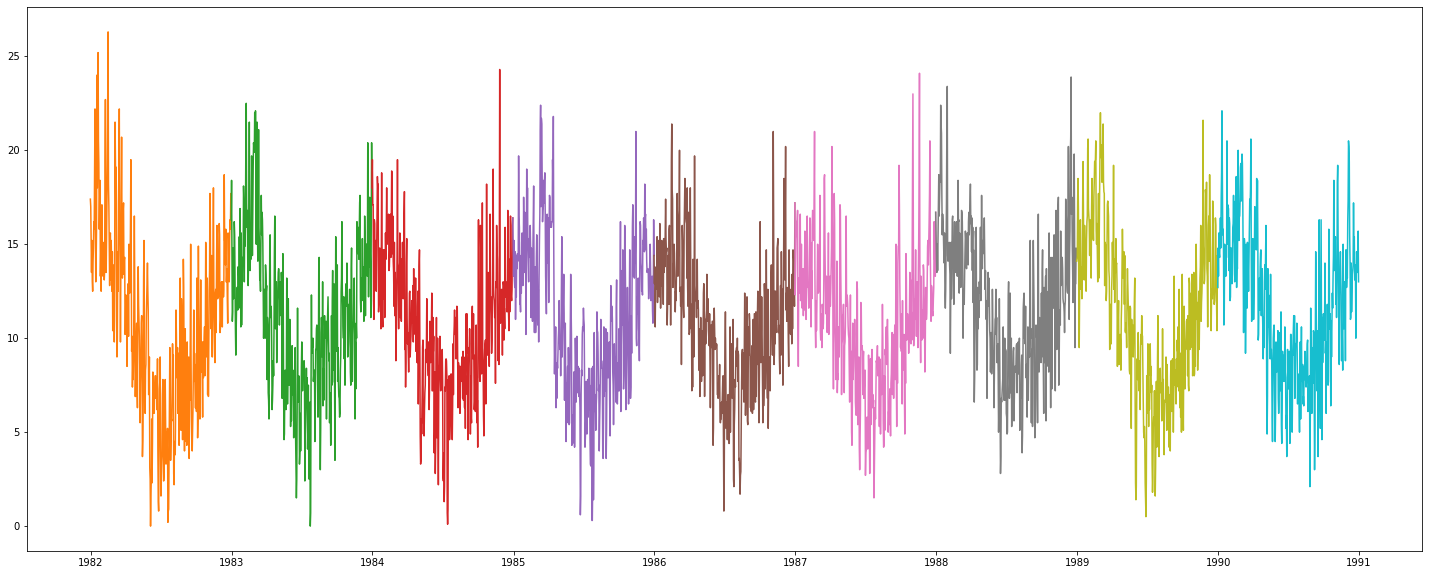

In [7]:
datified_df = df.copy()
datified_df['Date'] = pd.to_datetime(datified_df['Date'], format='%Y-%m-%d')
datified_df.set_index(datified_df['Date'], inplace=True)
datified_df = datified_df.drop(columns=['Date',])

plt.figure(figsize=(25, 10))

for year in range(0, 10):
  plt.plot(datified_df[(year * 365) - 1:(year * 365) + 365])

### Temperature in each month

An analysis of how the temperature distrbiutes in each year over the course of a ten year span (the total length of the dataset)

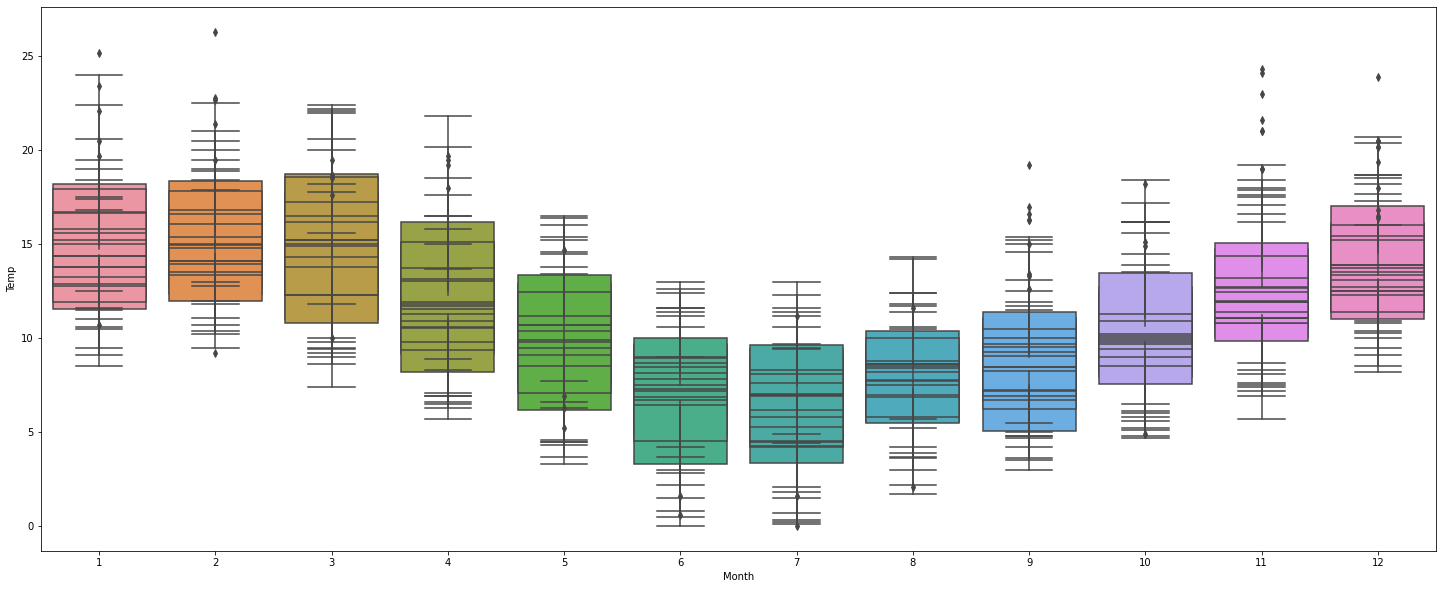

In [8]:
datified_df = df.copy()
datified_df['Year'] = datified_df['Date'].apply(lambda x: x.split('-')[0]).astype('int16')
datified_df['Month'] = datified_df['Date'].apply(lambda x: x.split('-')[1]).astype('int8')
datified_df['Day'] = datified_df['Date'].apply(lambda x: x.split('-')[2]).astype('int8')
datified_df['Date'] = pd.to_datetime(datified_df['Date'], format='%Y-%m-%d')
datified_df.set_index(datified_df['Date'], inplace=True)
datified_df = datified_df.drop(columns=['Date',])

plt.figure(figsize=(25, 10))

for year in range(0, 10):
  current_year_df = datified_df[(year * 365) - 1:(year * 365) + 365]
  if not len(current_year_df):
    continue
  sns.boxplot(data=current_year_df, x='Month', y='Temp')

### Temperature by month and day

It's a more insightful visualization, but more chaotically

Se prepara el nuevo dataframe

In [9]:
monthified_df = df.copy()

def map_date_features(row: pd.Series) -> pd.Series:
  new_row = row.copy(deep=True)

  # date features assignment
  year, month, day = row['Date'].split('-')
  new_row['Year'] = year
  new_row['Month'] = month
  new_row['Day'] = day

  return new_row

monthified_df = monthified_df.apply(map_date_features, axis=1)
monthified_df[ ['Year', 'Month', 'Day'] ] = monthified_df[ ['Year', 'Month', 'Day'] ].astype('int16')
monthified_df = monthified_df.drop(columns=['Date'])

months= {
  1: 'January',
  2: 'February',
  3: 'March',
  4: 'April',
  5: 'May',
  6: 'June',
  7: 'July',
  8: 'August',
  9: 'September',
  10: 'October',
  11: 'November',
  12: 'December',
}

monthified_df['Month'] = monthified_df['Month'].map(lambda x: months.get(x))

start_year = monthified_df.head(1)['Year'].values[0]
print('start_year', start_year)

start_year 1981


It's a visualization of each year by month and day, they're also caterpillars, take it as you want

<Figure size 1800x720 with 0 Axes>

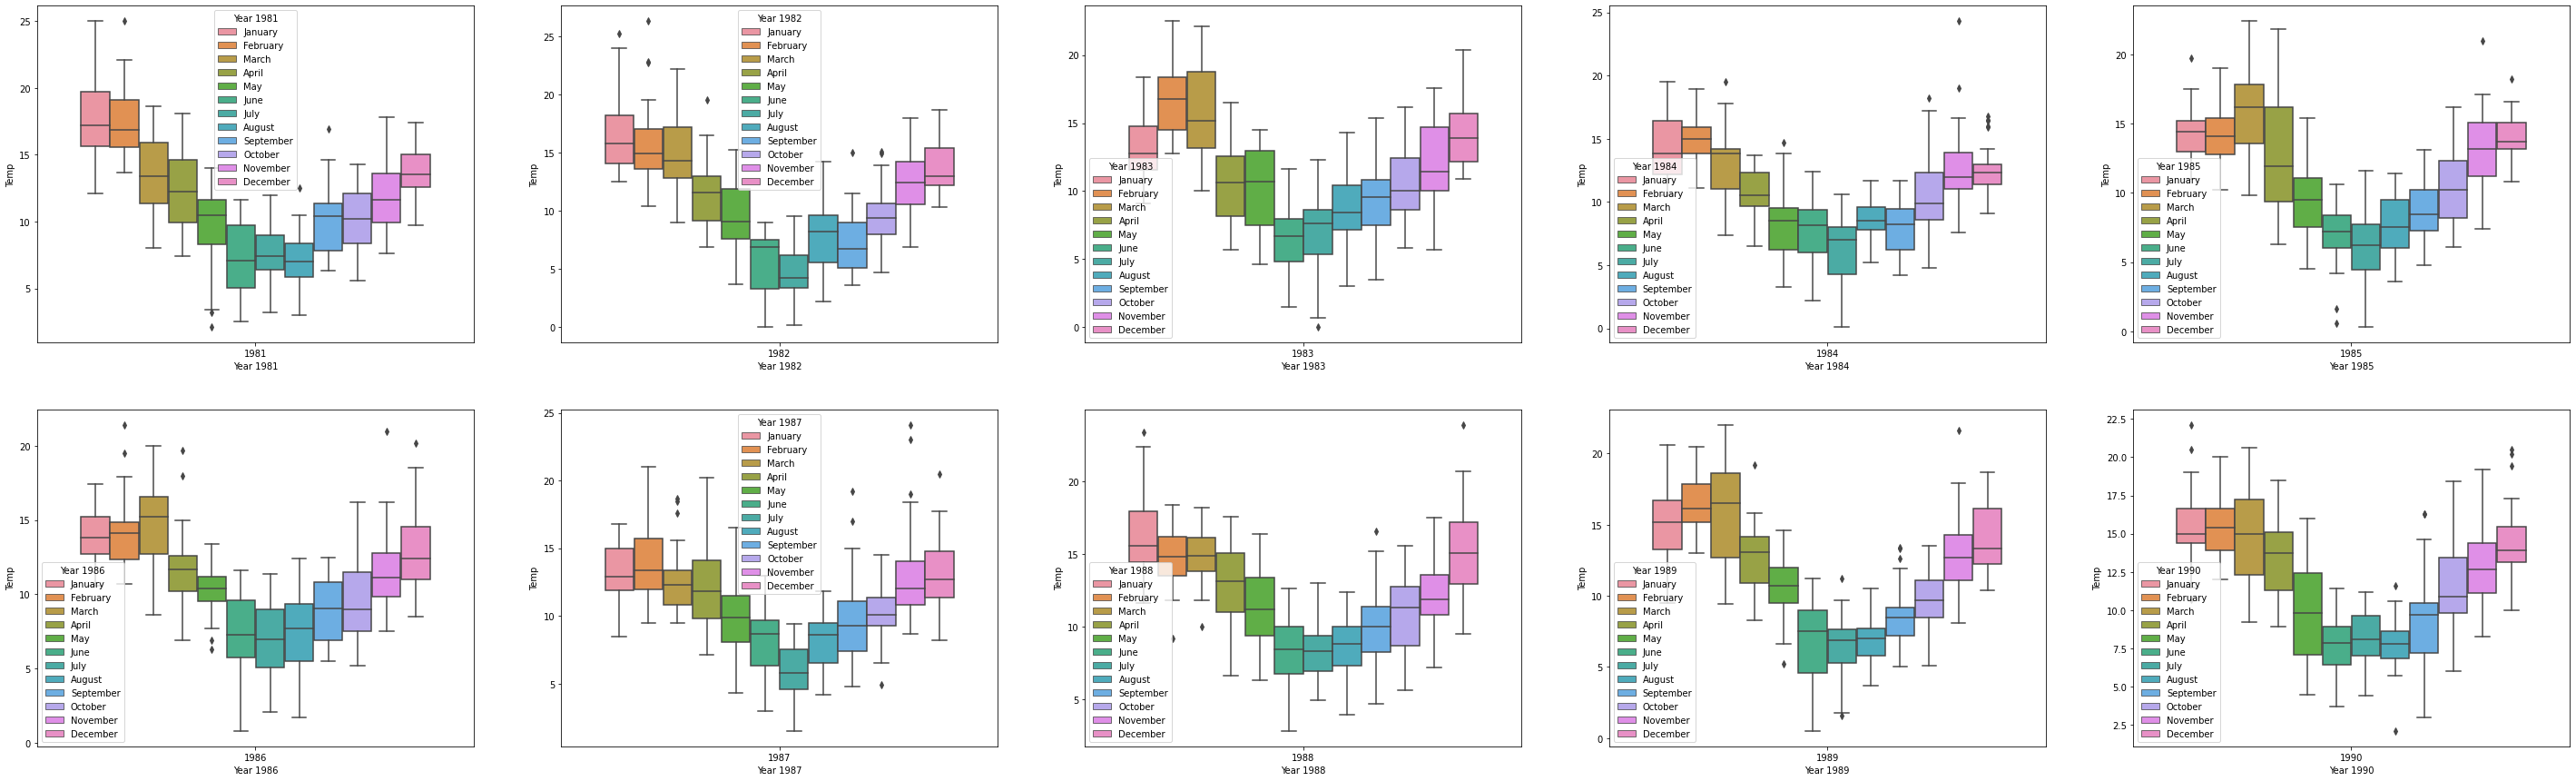

In [10]:
n_plots = 10
cols = 5
rows = int(np.ceil(n_plots / cols))
plt.figure(figsize=(25, 10))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 7.5))

for year in range(0, 10):
  current_year_days = year * 365
  current_window = monthified_df[current_year_days:current_year_days + 365]
  ax = axes[int(year / cols), int(year % cols)]
  g = sns.boxplot(ax=ax, data=current_window, x='Year', y='Temp', hue='Month', orient='v')
  title = f'Year {start_year + year}'
  ax.set_xlabel(title)
  ax.legend_.set_title(title)
  new_labels = months.values()
  for t, l in zip(ax.legend_.texts, new_labels):
      t.set_text(l)

### Timeseries distribution

We saw the range of temperature, but a violinplot can help us visualize the distribution of the temperature far more easily

<Figure size 1800x720 with 0 Axes>

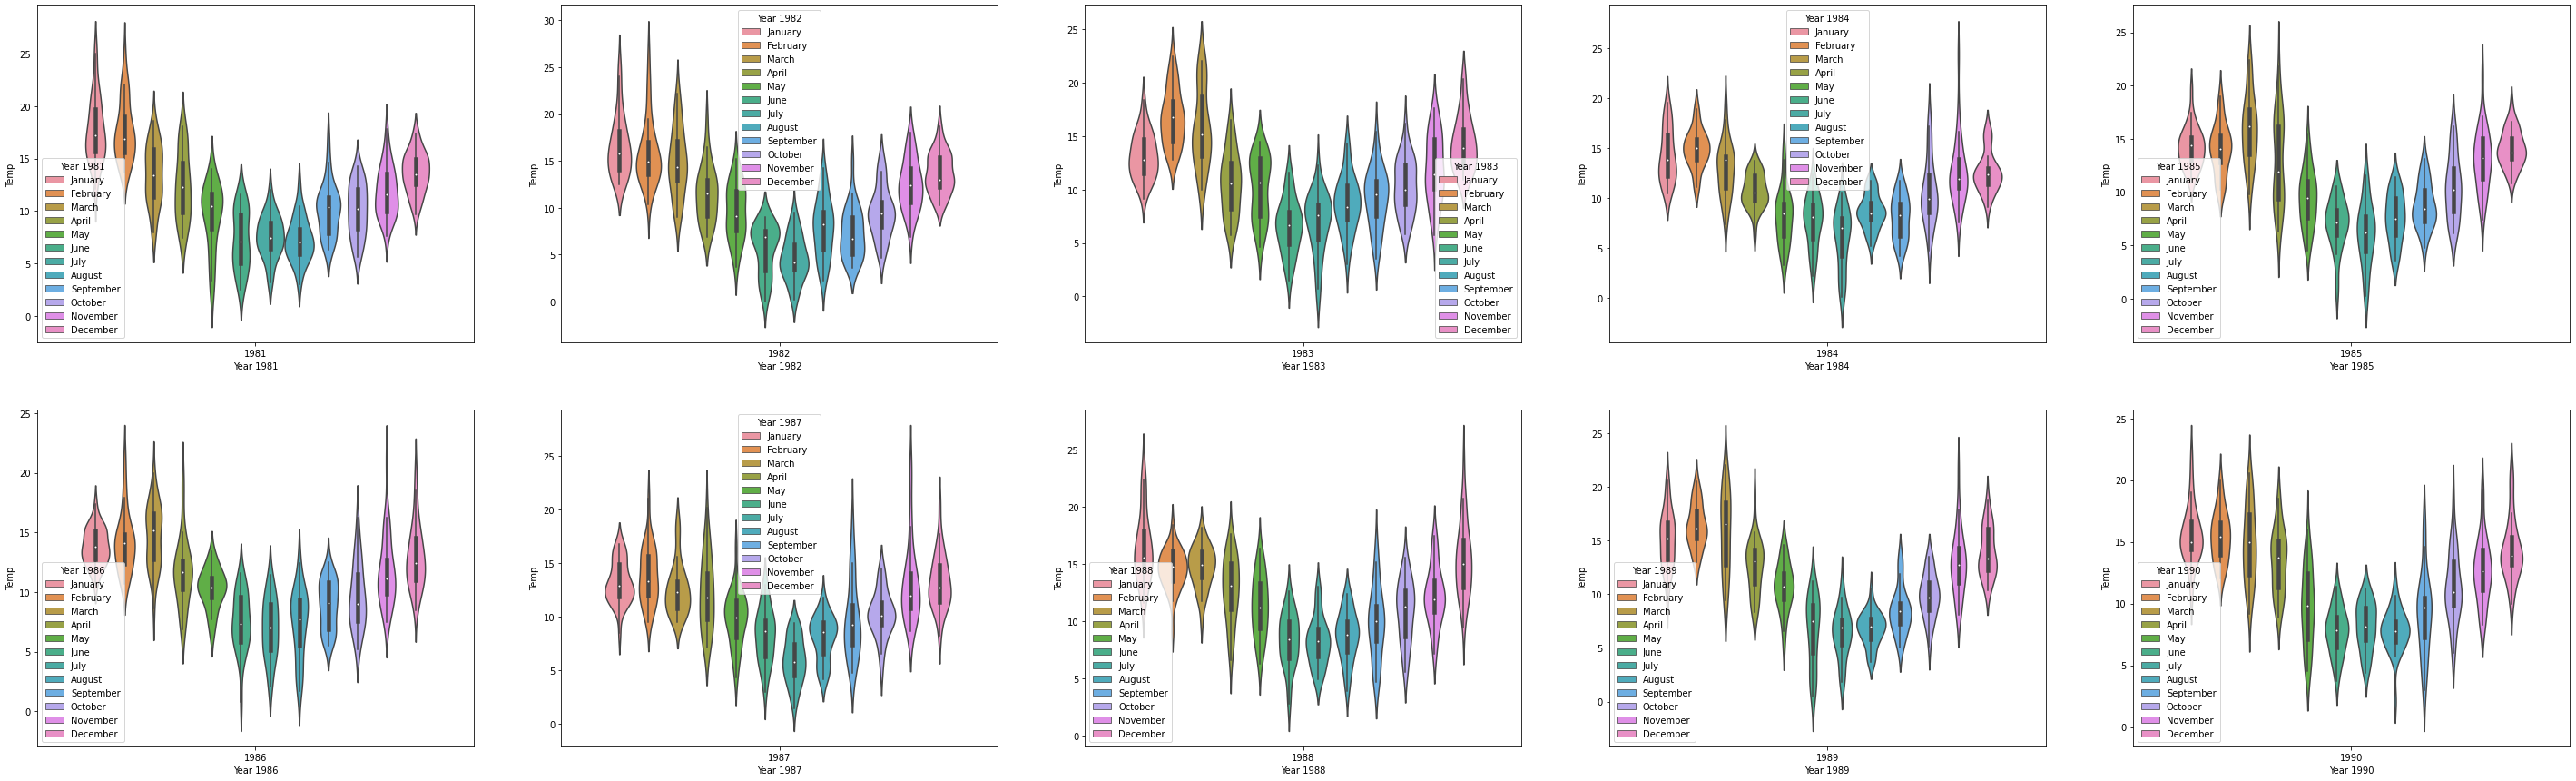

In [11]:
n_plots = 10
cols = 5
rows = int(np.ceil(n_plots / cols))
plt.figure(figsize=(25, 10))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 7.5))

for year in range(0, 10):
  current_year_days = year * 365
  current_window = monthified_df[current_year_days:current_year_days + 365]
  ax = axes[int(year / cols), int(year % cols)]
  g = sns.violinplot(ax=ax, data=current_window, x='Year', y='Temp', hue='Month', orient='v')
  title = f'Year {start_year + year}'
  ax.set_xlabel(title)
  ax.legend_.set_title(title)
  new_labels = months.values()
  for t, l in zip(ax.legend_.texts, new_labels):
      t.set_text(l)

## Data and environment preparation

Our models won't be working with the data right away, we need to make some slight adjustments and preparations

### Training preparations

Some preparation before getting hands on in the timeseries

The evaluation dictionaries (for a model comparison)

In [12]:
val_performance = dict()
performance = dict()

Our compile and fitting standarization so that all models have the same base

In [13]:
def compile_and_fit(
  model,
  window,
  patience: int = 2,
  epochs: int = 10
):
  """
  model
    The model to compile and fit
  window
    The time window
  patience
    The amount of epochs EarlyStopping will wait before stopping, if no positive progress was made
  """
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience
  )

  model.compile(
    loss=tf.losses.MeanAbsoluteError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[
      tf.metrics.MeanSquaredError(),
      tf.metrics.MeanAbsolutePercentageError(),
    ]
  )

  history = model.fit(
    window.train,
    epochs=epochs,
    validation_data=window.val,
    callbacks=[
      early_stopping
    ]
  )

  return history

The date type values from the timeseries dataset

In [14]:
date_values = df.pop('Date')
date_time = pd.to_datetime(date_values.apply(lambda x: f'{x}'), format='%Y-%m-%d')

A little check that everything's fine, and working as expected

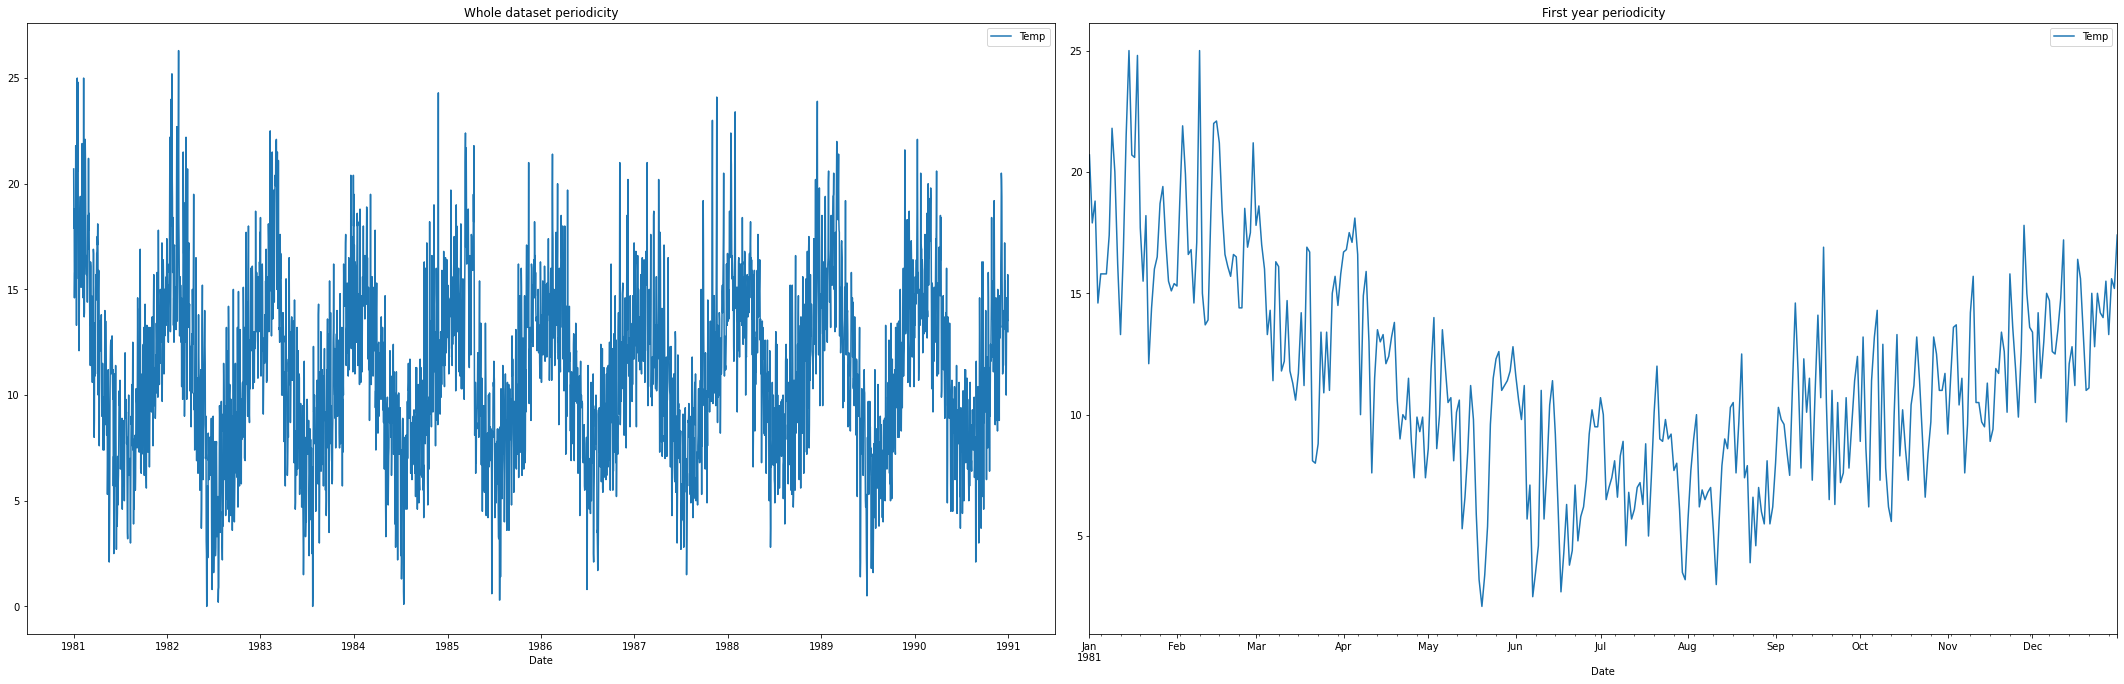

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

# For all the wanted periodity (10 years)
plot_cols = [LABEL_COLUMN]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, ax=axes[0])
axes[0].set_title('Whole dataset periodicity')

# For a single year
plot_features = df[plot_cols][:365]
plot_features.index = date_time[:365]
_ = plot_features.plot(subplots=True, ax=axes[1])
axes[1].set_title('First year periodicity')

# for a neat visualization
plt.tight_layout(pad=2.5, h_pad=.5, w_pad=1.5)

A little statistical insight

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


### Timestamp preparation

Timeseries is based on a value marked with a timestamp value

In [17]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Convert to sin and cos values that the model will uniquely identify as a specific moment in a year

In [18]:
day = 24*60*60
year = (365.2425) * day

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Some extracted values from the date itself

In [19]:
df['Year'] = date_values.map(lambda x: int(x.split('-')[0]))
df['Month'] = date_values.map(lambda x: int(x.split('-')[1]))
df['Day'] = date_values.map(lambda x: int(x.split('-')[2]))

The actual statistical information of the dataset

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.300000,11.000000,14.000000,26.300000
Year sin,3650.0,0.000007,0.707439,-1.0,-0.707563,0.001806,0.706768,1.000000
Year cos,3650.0,-0.000664,0.706968,-1.0,-0.708067,-0.000914,0.704757,0.999999
Year,3650.0,1985.500000,2.872675,1981.0,1983.000000,1985.500000,1988.000000,1990.000000
Month,3650.0,6.520548,3.447566,1.0,4.000000,7.000000,10.000000,12.000000
Day,3650.0,15.719452,8.795673,1.0,8.000000,16.000000,23.000000,31.000000


And now a quick "health" check that it actually computes the visualization it should, without any gapes

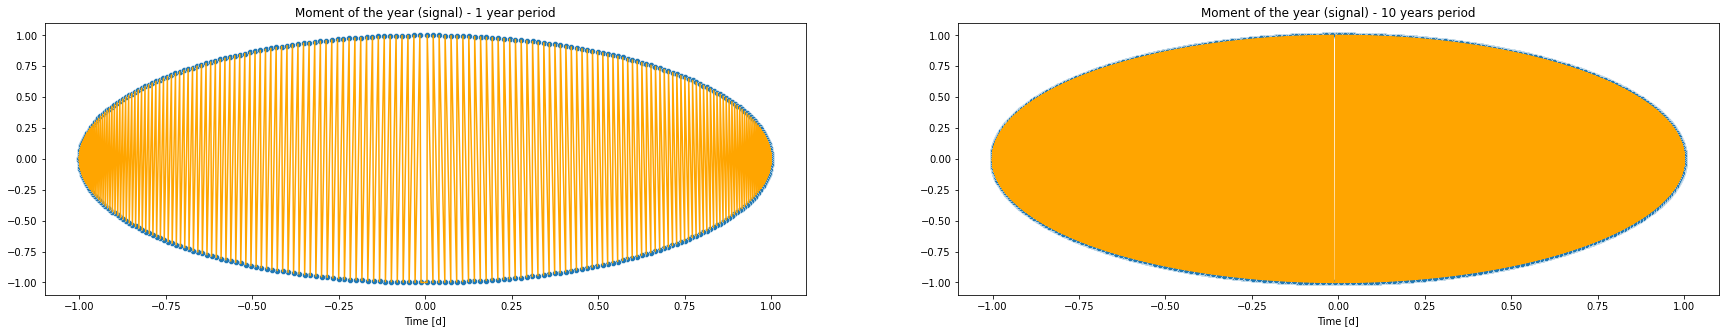

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(30, 5))

# one year period
sns.scatterplot(data=df[:365], x=np.array(df['Year sin'])[:365], y=np.array(df['Year cos'])[:365], ax=axes[0]).set(
    xlabel='Time [d]', title='Moment of the year (signal) - 1 year period',
)
sns.lineplot(data=df[:365], x=np.array(df['Year sin'])[:365], y=np.array(df['Year cos'])[:365], ax=axes[0], color='orange')

# full dataset
sns.scatterplot(data=df, x=np.array(df['Year sin']), y=np.array(df['Year cos']), ax=axes[1]).set(
    xlabel='Time [d]', title='Moment of the year (signal) - 10 years period',
)
sns.lineplot(data=df, x=np.array(df['Year sin']), y=np.array(df['Year cos']), ax=axes[1], color='orange')

Here we can evaluate more cycles easily

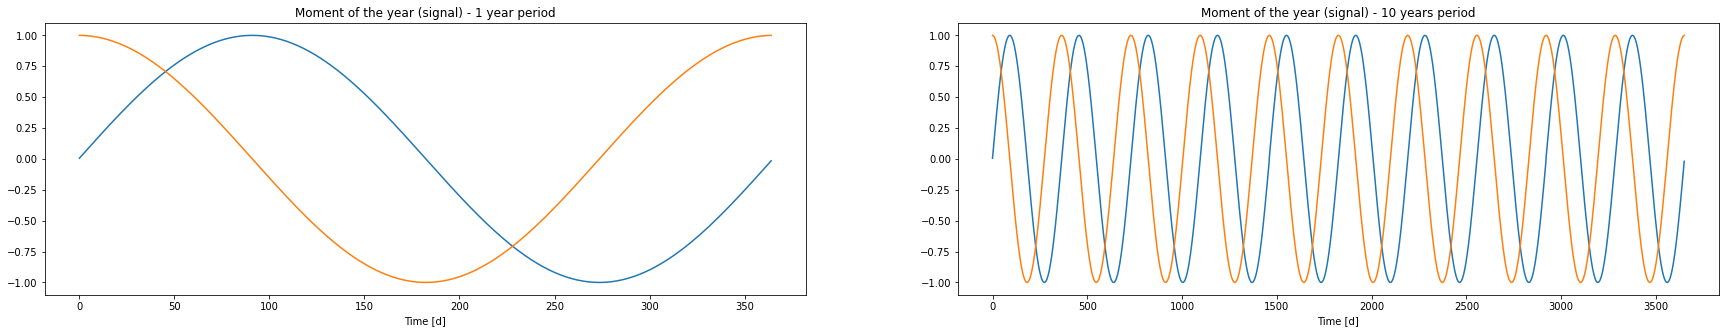

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(30, 5))

# one year period
sns.lineplot(data=np.array(df['Year sin'])[:365], ax=axes[0]).set(
    xlabel='Time [d]',
    title='Moment of the year (signal) - 1 year period',
)
sns.lineplot(data=np.array(df['Year cos'][:365]), ax=axes[0])

# full dataset
sns.lineplot(data=np.array(df['Year sin']), ax=axes[1]).set(
    xlabel='Time [d]',
    title='Moment of the year (signal) - 10 years period',
)
sns.lineplot(data=np.array(df['Year cos']), ax=axes[1])

### Set splitting

We have to manually split the values into it's different sets, we'll do it manually since it's required that the values are in chronological order

In [23]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Data normalization

All values should be between zero and one, and with as minimal std as possible, while having some deviation.

In [24]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

Let's visualize it's results

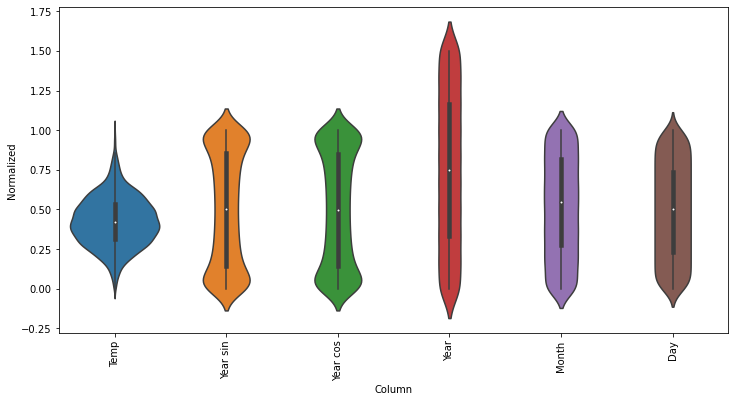

In [25]:
df_std = (df - train_min) / (train_max - train_min)
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

And that everything is as it should

In [26]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,2555.0,0.417566,0.155475,0.0,0.307985,0.414449,0.520913,1.0
Year sin,2555.0,0.500003,0.353740,0.0,0.146331,0.500774,0.853669,1.0
Year cos,2555.0,0.499668,0.353505,0.0,0.146240,0.499554,0.852292,1.0
Year,2555.0,0.500000,0.333399,0.0,0.166667,0.500000,0.833333,1.0
Month,2555.0,0.502010,0.313453,0.0,0.272727,0.545455,0.818182,1.0
Day,2555.0,0.490659,0.293223,0.0,0.233333,0.500000,0.733333,1.0


## WindowGenerator

Straight from:

- https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df


    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Tamaño total de la ventana: {self.total_window_size}',
        f'Índices de entrada: {self.input_indices}',
        f'Índices de salida: {self.label_indices}',
        f'Columnas de salida: {self.label_columns}'])

### Split window

Generates a time window

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Plot

Visualize the time window, and the predictions if available

In [29]:
def plot(self, model=None, plot_col='Temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
      
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### Make dataset

Create a set of data for timeseries

In [30]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

### Dataset properties

The train, test, validation sets of data, and an example one for testing

In [31]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Plot explainability

In [32]:
def plot_explainability(
  model
) -> None:
  plt.bar(
    x=range(len(train_df.columns)),
    height=model.layers[0].kernel[:,0].numpy()
  )
  axis = plt.gca()
  axis.set_xticks(range(len(train_df.columns)))
  _ = axis.set_xticklabels(train_df.columns, rotation=90)

## Single Step

You can lear about the algorithms in much greater detail at:

- https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models

### Time Window

In [33]:
single_step_window = WindowGenerator(
  input_width=1,
  label_width=1,
  shift=1,
  label_columns=[LABEL_COLUMN,]
)
single_step_window

Tamaño total de la ventana: 2
Índices de entrada: [0]
Índices de salida: [1]
Columnas de salida: ['Temp']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print('example_inputs', example_inputs.shape)
  print('example_labels', example_labels.shape)

example_inputs (32, 1, 6)
example_labels (32, 1, 1)


In [35]:
for example_inputs, example_labels in single_step_window.val.take(1):
  print('example_inputs', example_inputs.shape)
  print('example_labels', example_labels.shape)

example_inputs (32, 1, 6)
example_labels (32, 1, 1)


In [36]:
for example_inputs, example_labels in single_step_window.test.take(1):
  print('example_inputs', example_inputs.shape)
  print('example_labels', example_labels.shape)

example_inputs (32, 1, 6)
example_labels (32, 1, 1)


In [37]:
wide_window = WindowGenerator(
  input_width=7,
  label_width=7,
  shift=1,
  label_columns=[LABEL_COLUMN,],
)
wide_window

Tamaño total de la ventana: 8
Índices de entrada: [0 1 2 3 4 5 6]
Índices de salida: [1 2 3 4 5 6 7]
Columnas de salida: ['Temp']

In [38]:
for example_inputs, example_labels in wide_window.train.take(1):
  print('example_inputs', example_inputs.shape)
  print('example_labels', example_labels.shape)

example_inputs (32, 7, 6)
example_labels (32, 7, 1)


### Baseline

In [39]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [40]:
baseline = Baseline(
  label_index=column_indices[LABEL_COLUMN]
)
baseline.compile(
  loss=tf.losses.MeanSquaredError(),
  metrics=[
    tf.metrics.MeanAbsoluteError(),
    tf.metrics.MeanAbsolutePercentageError(),
  ]
)

val_performance['Baseline'] = baseline.evaluate(
  single_step_window.val
)
performance['Baseline'] = baseline.evaluate(
  single_step_window.test,
  verbose=0
)

23/23 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_error: 0.0763 - mean_absolute_percentage_error: 21.1425


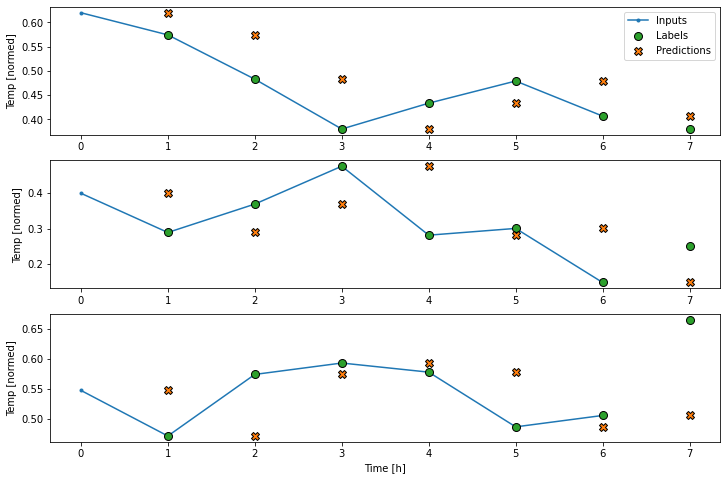

In [41]:
wide_window.plot(baseline)

### Linear

In [42]:
linear = tf.keras.Sequential([
  tf.keras.layers.Dense(
    units=1
  ),
])

In [43]:
history = compile_and_fit(
  linear,
  single_step_window,
  epochs=50
)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

Epoch 1/50
80/80 [==============================] - 1s 8ms/step - loss: 0.2791 - mean_squared_error: 0.1170 - mean_absolute_percentage_error: 125384.5312 - val_loss: 0.3315 - val_mean_squared_error: 0.1605 - val_mean_absolute_percentage_error: 100.8406
Epoch 2/50
80/80 [==============================] - 1s 6ms/step - loss: 0.2453 - mean_squared_error: 0.0908 - mean_absolute_percentage_error: 106060.0938 - val_loss: 0.2920 - val_mean_squared_error: 0.1237 - val_mean_absolute_percentage_error: 89.8466
Epoch 3/50
80/80 [==============================] - 1s 6ms/step - loss: 0.2143 - mean_squared_error: 0.0698 - mean_absolute_percentage_error: 90711.6953 - val_loss: 0.2596 - val_mean_squared_error: 0.0972 - val_mean_absolute_percentage_error: 80.6296
Epoch 4/50
80/80 [==============================] - 0s 6ms/step - loss: 0.1867 - mean_squared_error: 0.0533 - mean_absolute_percentage_error: 79741.2969 - val_loss: 0.2283 - val_mean_squared_error: 0.0750 - val_mean_absolute_percentage_error: 7

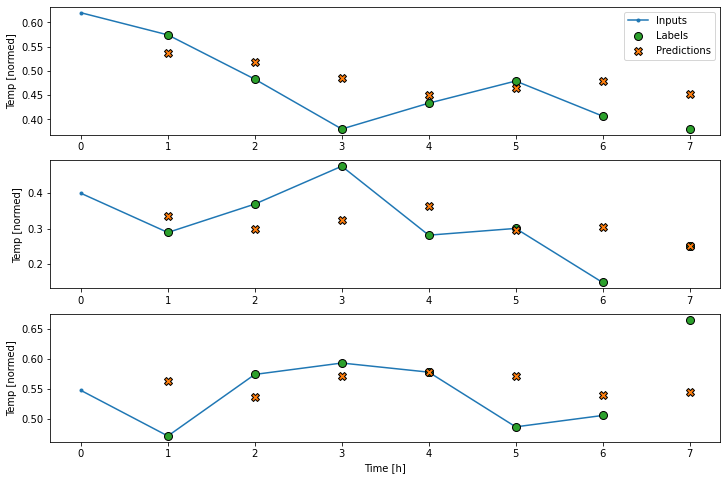

In [44]:
wide_window.plot(linear)

In [45]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

12/12 [==============================] - 0s 2ms/step - loss: 0.0725 - mean_squared_error: 0.0086 - mean_absolute_percentage_error: 18.0567


#### Dependant variable explainability

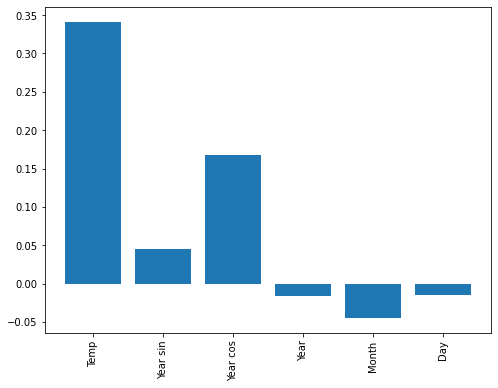

In [46]:
plot_explainability(linear)

### Dense

In [47]:
dense = tf.keras.Sequential([
  tf.keras.layers.Dense(
    units=64,
    activation='relu'
  ),
  tf.keras.layers.Dense(
    units=64,
    activation='relu'
  ),
  tf.keras.layers.Dense(
    units=1
  ),
])

In [48]:
history = compile_and_fit(
  dense,
  single_step_window,
)

Epoch 1/10
80/80 [==============================] - 1s 8ms/step - loss: 0.1203 - mean_squared_error: 0.0301 - mean_absolute_percentage_error: 209758.3281 - val_loss: 0.0786 - val_mean_squared_error: 0.0097 - val_mean_absolute_percentage_error: 26.1627
Epoch 2/10
80/80 [==============================] - 0s 6ms/step - loss: 0.0756 - mean_squared_error: 0.0092 - mean_absolute_percentage_error: 192106.9844 - val_loss: 0.0754 - val_mean_squared_error: 0.0090 - val_mean_absolute_percentage_error: 24.9063
Epoch 3/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0737 - mean_squared_error: 0.0087 - mean_absolute_percentage_error: 176595.1562 - val_loss: 0.0729 - val_mean_squared_error: 0.0085 - val_mean_absolute_percentage_error: 24.2845
Epoch 4/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0739 - mean_squared_error: 0.0089 - mean_absolute_percentage_error: 175422.2656 - val_loss: 0.0730 - val_mean_squared_error: 0.0084 - val_mean_absolute_percentage_error: 

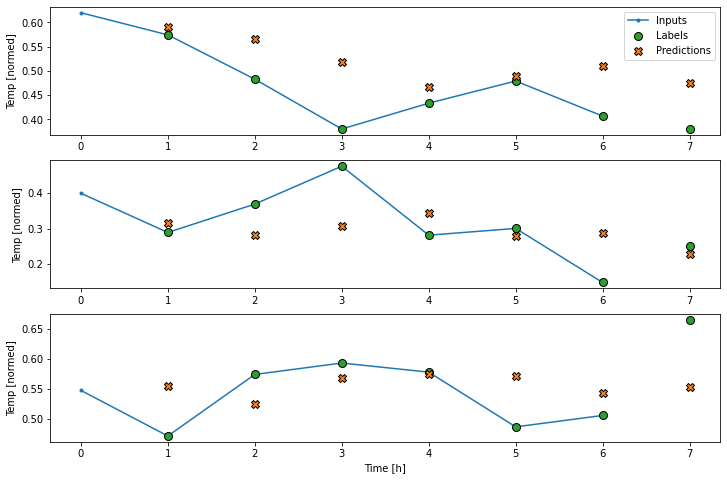

In [49]:
wide_window.plot(dense)

In [50]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

12/12 [==============================] - 0s 3ms/step - loss: 0.0678 - mean_squared_error: 0.0076 - mean_absolute_percentage_error: 18.3895


#### Dependant variable explainability

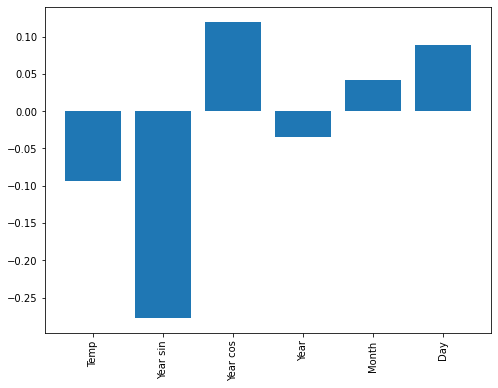

In [51]:
plot_explainability(dense)

### LSTM

In [52]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(
    units=128,
    return_sequences=True
  ),
  tf.keras.layers.Dense(
    units=1
  )
])

In [53]:
history = compile_and_fit(
  lstm_model,
  wide_window,
  epochs=50
)

Epoch 1/50
80/80 [==============================] - 4s 18ms/step - loss: 0.1153 - mean_squared_error: 0.0237 - mean_absolute_percentage_error: 209002.8594 - val_loss: 0.0830 - val_mean_squared_error: 0.0111 - val_mean_absolute_percentage_error: 25.7813
Epoch 2/50
80/80 [==============================] - 1s 12ms/step - loss: 0.0808 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 204634.4688 - val_loss: 0.0752 - val_mean_squared_error: 0.0092 - val_mean_absolute_percentage_error: 23.0647
Epoch 3/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0758 - mean_squared_error: 0.0093 - mean_absolute_percentage_error: 203289.6875 - val_loss: 0.0759 - val_mean_squared_error: 0.0092 - val_mean_absolute_percentage_error: 22.1088
Epoch 4/50
80/80 [==============================] - 1s 11ms/step - loss: 0.0743 - mean_squared_error: 0.0089 - mean_absolute_percentage_error: 194252.5469 - val_loss: 0.0706 - val_mean_squared_error: 0.0080 - val_mean_absolute_percentage_err

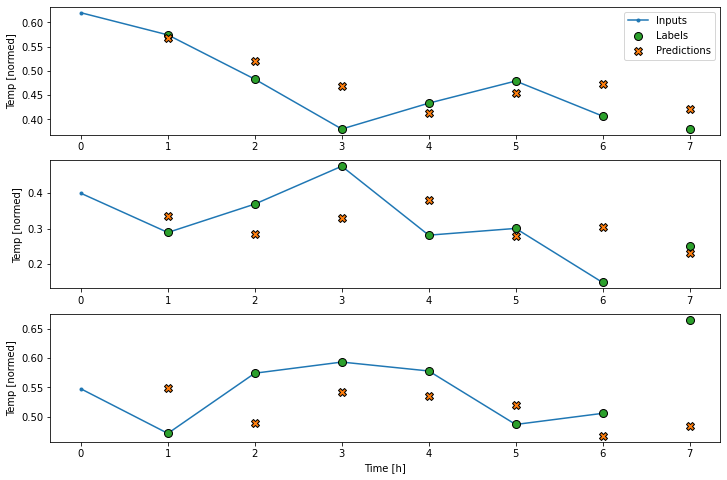

In [54]:
wide_window.plot(lstm_model)

In [55]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

12/12 [==============================] - 0s 3ms/step - loss: 0.0719 - mean_squared_error: 0.0084 - mean_absolute_percentage_error: 18.4355


## Multi Step

You can lear about the algorithms in much greater detail at:

- https://www.tensorflow.org/tutorials/structured_data/time_series

### Time Window

Tamaño total de la ventana: 35
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Índices de salida: [28 29 30 31 32 33 34]
Columnas de salida: ['Temp']

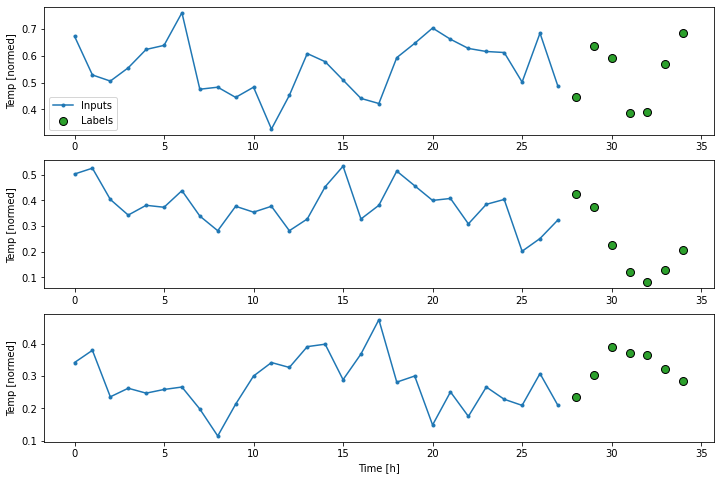

In [56]:
OUT_STEPS = 7
multi_window = WindowGenerator(
  input_width=28,
  label_width=OUT_STEPS,
  shift=OUT_STEPS,
  label_columns=[LABEL_COLUMN,]
)

multi_window.plot()
multi_window

### Single Shot

In [57]:
single_shot_single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[LABEL_COLUMN,])
single_shot_wide_window = WindowGenerator(input_width=28, label_width=1, shift=1, label_columns=[LABEL_COLUMN,])

dense = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation ='relu'),
  tf.keras.layers.Dense(units=64, activation ='relu'),
  tf.keras.layers.Dense(units=1),
  tf.keras.layers.Reshape([1, -1])
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/10
80/80 [==============================] - 1s 7ms/step - loss: 0.1025 - mean_squared_error: 0.0197 - mean_absolute_percentage_error: 182681.6719 - val_loss: 0.0771 - val_mean_squared_error: 0.0097 - val_mean_absolute_percentage_error: 23.8370
Epoch 2/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0751 - mean_squared_error: 0.0091 - mean_absolute_percentage_error: 167149.1719 - val_loss: 0.0786 - val_mean_squared_error: 0.0098 - val_mean_absolute_percentage_error: 21.7187
Epoch 3/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0744 - mean_squared_error: 0.0089 - mean_absolute_percentage_error: 176907.1562 - val_loss: 0.0707 - val_mean_squared_error: 0.0081 - val_mean_absolute_percentage_error: 20.8220
Epoch 4/10
80/80 [==============================] - 1s 6ms/step - loss: 0.0765 - mean_squared_error: 0.0095 - mean_absolute_percentage_error: 175897.0938 - val_loss: 0.0828 - val_mean_squared_error: 0.0107 - val_mean_absolute_percentage_error: 

### Dense

In [58]:
multi_dense_model = tf.keras.Sequential([
  # Mandatory in multi-step models
  tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
  tf.keras.layers.Dense(
    units=64,
    activation='relu',
    name='Hidden-Layer'
  ),
  tf.keras.layers.Dense(
    units=OUT_STEPS,
    name='Output-Layer',
    kernel_initializer=tf.initializers.zeros()
  ),
  tf.keras.layers.Reshape([OUT_STEPS, 1])
])

In [59]:
history = compile_and_fit(
  multi_dense_model,
  multi_window,
)

Epoch 1/10
79/79 [==============================] - 1s 8ms/step - loss: 0.1637 - mean_squared_error: 0.0479 - mean_absolute_percentage_error: 174311.4062 - val_loss: 0.0833 - val_mean_squared_error: 0.0113 - val_mean_absolute_percentage_error: 31.0175
Epoch 2/10
79/79 [==============================] - 0s 6ms/step - loss: 0.0841 - mean_squared_error: 0.0115 - mean_absolute_percentage_error: 226636.2656 - val_loss: 0.0781 - val_mean_squared_error: 0.0100 - val_mean_absolute_percentage_error: 26.8425
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - loss: 0.0830 - mean_squared_error: 0.0111 - mean_absolute_percentage_error: 222386.1719 - val_loss: 0.0795 - val_mean_squared_error: 0.0103 - val_mean_absolute_percentage_error: 26.4324
Epoch 4/10
79/79 [==============================] - 1s 6ms/step - loss: 0.0824 - mean_squared_error: 0.0110 - mean_absolute_percentage_error: 224550.7969 - val_loss: 0.0806 - val_mean_squared_error: 0.0105 - val_mean_absolute_percentage_error: 

In [60]:
val_performance['Multi-Step Dense'] = multi_dense_model.evaluate(multi_window.val)
performance['Multi-Step Dense'] = multi_dense_model.evaluate(multi_window.test)

11/11 [==============================] - 0s 2ms/step - loss: 0.0786 - mean_squared_error: 0.0101 - mean_absolute_percentage_error: 23.3982


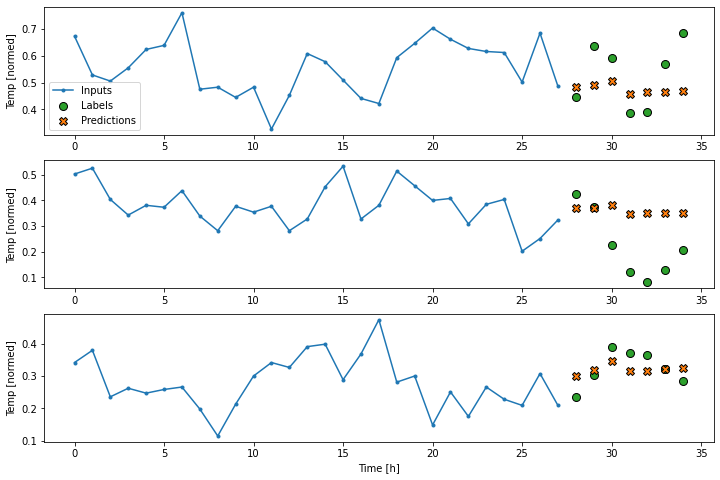

In [61]:
multi_window.plot(multi_dense_model)

### LSTM Long Short-Term Memory

In [62]:
multi_lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(
    units=32,
    return_sequences=False
  ),
  tf.keras.layers.Dense(
    units=OUT_STEPS * 1,
    name='Output-Layer',
    kernel_initializer=tf.initializers.zeros()
  ),
  tf.keras.layers.Reshape([
    OUT_STEPS,
    1
  ])
])

Train

In [63]:
history = compile_and_fit(
  multi_lstm_model,
  multi_window,
)

Epoch 1/10
79/79 [==============================] - 4s 21ms/step - loss: 0.1687 - mean_squared_error: 0.0501 - mean_absolute_percentage_error: 205343.2969 - val_loss: 0.0864 - val_mean_squared_error: 0.0123 - val_mean_absolute_percentage_error: 30.9560
Epoch 2/10
79/79 [==============================] - 1s 15ms/step - loss: 0.0846 - mean_squared_error: 0.0118 - mean_absolute_percentage_error: 240693.5938 - val_loss: 0.0887 - val_mean_squared_error: 0.0129 - val_mean_absolute_percentage_error: 26.7154
Epoch 3/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0834 - mean_squared_error: 0.0113 - mean_absolute_percentage_error: 229004.0000 - val_loss: 0.0854 - val_mean_squared_error: 0.0119 - val_mean_absolute_percentage_error: 28.1039
Epoch 4/10
79/79 [==============================] - 1s 14ms/step - loss: 0.0842 - mean_squared_error: 0.0115 - mean_absolute_percentage_error: 232736.5938 - val_loss: 0.0841 - val_mean_squared_error: 0.0116 - val_mean_absolute_percentage_err

Visualize

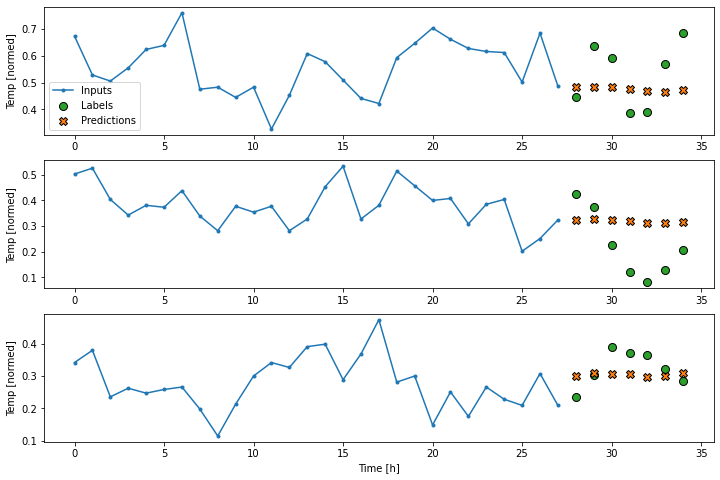

In [64]:
multi_window.plot(multi_lstm_model)

And evaluate

In [65]:
val_performance['Multi-Step LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['Multi-Step LSTM'] = multi_lstm_model.evaluate(multi_window.test)

11/11 [==============================] - 0s 4ms/step - loss: 0.0861 - mean_squared_error: 0.0124 - mean_absolute_percentage_error: 21.7532


## Model comparison

Now it's time to evaluate the results of each model, the result was calculated using the error

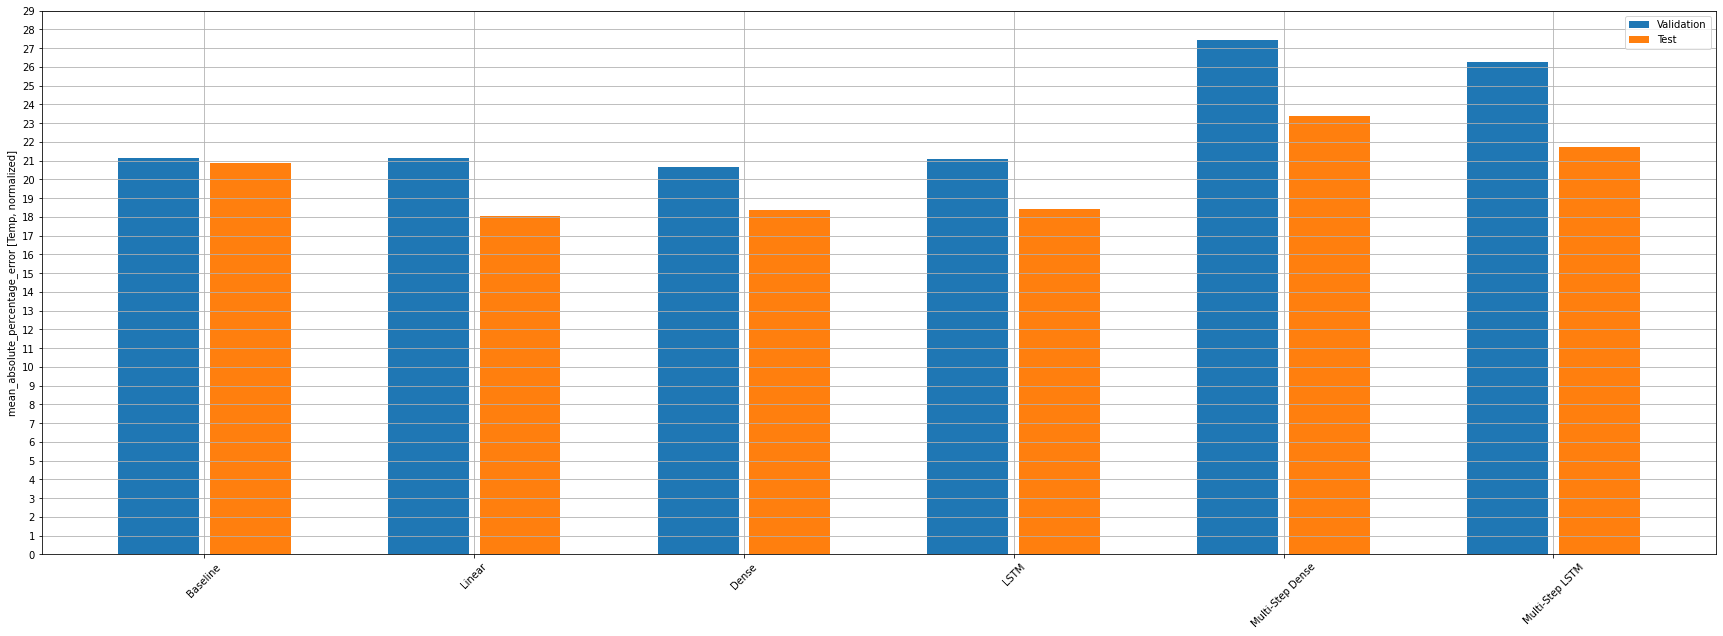

In [66]:
plt.figure(figsize=(30, 10))

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'{metric_name} [Temp, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.yticks(range(0, 30))
plt.legend()
plt.grid()

## Conclusions

Having a consistent dataset (daily without a miss) for 10 straight years is a great starting point, but it's just that, a starting point, without any other feature that could contribute to the temperature prediction it becomes really hard to actually get accurate predictions, even more for a whole straight week.

I'd guess that if we had hour, or even minute detail, it may be more precise, but I can't tell for certain.